# Name Verification 

In this notebook I will work with data combine, preprocess, explore and generate the final dataset to train the model, train the model and try predict method

## 1. Importing Packages

In [2]:
import os
import sys
import joblib
import pandas as pd

sys.path.append(os.path.realpath('..'))

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from src import( Preprocess,
                 Explorer,
                 Visualizer,
                 DataGenerator,
                 Tokenizer,
                 Evaluator,
                 VerificationModel, 
                 DetectOverFitting,
                 Prediction )

## 2. Dataset

### 2.1. Load Data

I have 3 dataset
1. `Arabic_names.csv`: contains males and females names
2. `fnames.txt`: contains females names only
3. `mnames.txt`: contains males names only 

In [ ]:
# define paths
data1_path = '../data/raw/Arabic_names.csv'
data2_path = '../data/raw/fnames.txt'
data3_path = '../data/raw/mnames.txt'

preprocess = Preprocess()

In [ ]:
data1 = pd.read_csv(data1_path)
data1.head()

,Name,Gender
0,ابتسام,F
1,ابتهاج,F
2,ابتهال,F
3,اجتهاد,F
4,ازدهار,F


In [ ]:
print('Data1 length: {}'.format(len(data1)))

Data1 length: 1405


In [ ]:
data2 = preprocess.load_txt_data(data_path=data2_path, gender = 'F')
data2.head()

,Name,Gender
0,آيات,F
1,آلاء,F
2,آمال,F
3,آمنة,F
4,آيات,F


In [ ]:
print('Data2 length: {}'.format(len(data2)))

Data2 length: 416


In [ ]:
data3 = preprocess.load_txt_data(data_path=data3_path, gender = 'M')
data3.head()

,Name,Gender
0,أبان,M
1,أبو بكر,M
2,أبو حمزة,M
3,أحد,M
4,أحمد,M


In [ ]:
print('Data3 length: {}'.format(len(data3)))

Data3 length: 640


Now I will combine these data together

In [ ]:
data = preprocess.combine_data([data1, data2, data3])

### 2.2. Clean data and Get familiar with it

Now lets explore data

In [ ]:
explorer = Explorer(data=data)

In [ ]:
data.head()

,Name,Gender
0,ابتسام,F
1,ابتهاج,F
2,ابتهال,F
3,اجتهاد,F
4,ازدهار,F


In [ ]:
data.tail()

,Name,Gender
2456,وفيق,M
2457,وهاب,M
2458,وهبة,M
2459,ياسر,M
2460,يحيى,M


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2461 entries, 0 to 2460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    2461 non-null   object
 1   Gender  2461 non-null   object
dtypes: object(2)
memory usage: 38.6+ KB


There are no null values let's check if there are duplicated rows

In [ ]:
explorer.get_duplicated_rows()

,Name,Gender
1405,آيات,F
1406,آلاء,F
1407,آمال,F
1408,آمنة,F
1409,آيات,F
...,...,...
2456,وفيق,M
2457,وهاب,M
2458,وهبة,M
2459,ياسر,M


There are a lot of repated rows from combined data I will drop them

In [ ]:
data = preprocess.delete_duplicated_raws(data)

Now let's check the data again

In [ ]:
explorer = Explorer(data=data)
visualizer = Visualizer(data=data)

In [ ]:
explorer.get_duplicated_rows()

,Name,Gender


In [ ]:
explorer.get_gender_counts()

M    959
F    635
Name: Gender, dtype: int64

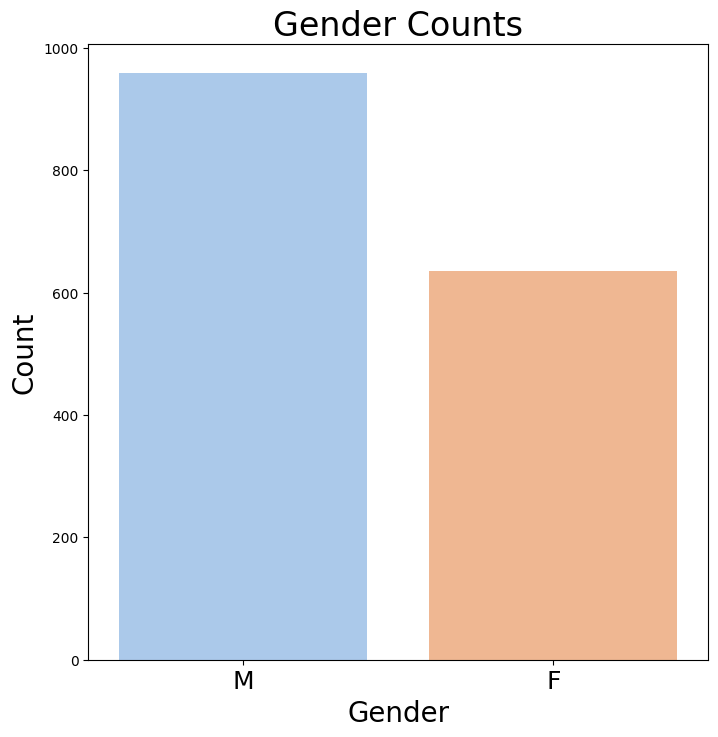

In [ ]:
visualizer.show_gender_counts('gender_counts')

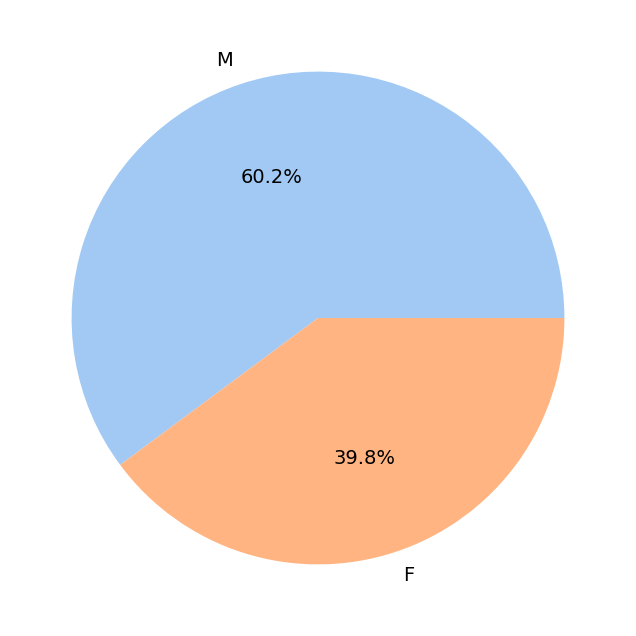

In [ ]:
visualizer.show_percentage('gender_percentage')

There are some names consist of two parts lets handle this

In [ ]:
explorer.get_double_names()

,Name,Gender
0,أم كلثوم,F
1,أبو بكر,M
2,شمس الدين,M
3,صلاح الدين,M
4,علاء الدين,M
5,معين الدين,M
6,ناصر الدين,M
7,نجم الدين,M
8,ولاء الدين,M
9,سعيدة بضم السين,F


I will replace the space`" "` between the two names with `-` and drop  `سعيدة بضم السين`

In [ ]:
data = preprocess.handle_double_names(data)

In [ ]:
explorer = Explorer(data)
explorer.get_double_names()

,Name,Gender


There are some names that are considered male or female names

In [ ]:
mf_names = explorer.get_duplicate_names()
mf_names

,Name,Gender
72,إحسان,F
102,براء,F
106,بشري,F
112,بيان,F
124,تيسير,F
...,...,...
1553,فاتن,M
1576,ميار,M
1579,نجد,M
1581,ندرة,M


In [ ]:
names = list(mf_names['Name'].unique())
names

['إحسان',
 'براء',
 'بشري',
 'بيان',
 'تيسير',
 'ثراء',
 'جبلة',
 'دانا',
 'رجاء',
 'رضا',
 'رمزية',
 'سلامة',
 'ضياء',
 'طيب',
 'عابدة',
 'عبادة',
 'عزة',
 'غيد',
 'فاتن',
 'ميار',
 'نجد',
 'نسيم',
 'نصر',
 'نضال',
 'نعيم',
 'نوار',
 'نورس',
 'هدير',
 'ورد',
 'وسام',
 'وهبة',
 'أمية',
 'حجاب',
 'رجب',
 'رياض',
 'عتابة',
 'عشير',
 'عنبر',
 'فضل',
 'مارسيل',
 'مرحب',
 'هريرة',
 'ندرة']

### 2.3. Save Data

In [ ]:
data.to_csv("../data/processed/processed_data.csv", index=False)

In [ ]:
# save male female names to use it correctly in data generation
joblib.dump(names, "../data/processed/fm_names.pkl")

['../data/processed/fm_names.pkl']

## 3. Data Generation

#### 3.1 load data

In [ ]:
data = pd.read_csv('../data/processed/processed_data.csv')

In [ ]:
data.head()

,Name,Gender
0,ابتسام,F
1,ابتهاج,F
2,ابتهال,F
3,اجتهاد,F
4,ازدهار,F


#### 3.2 Generate data

The data consist of trple name and if the name is correct or not <br>
1. The arabic names consist of [`son name` + `father name` + `grandpa name`] <br>
2. The real name will consist of [`male or female name` + `male name` + `male name`]
3. The fake name consist of real name with three char changed randomly or the father or grandfather name is female name

In [ ]:
generator = DataGenerator(data)

In [ ]:
real_data = generator.generate_real_data(2000000)

In [ ]:
real_data.head()

,name,correct
0,أنسام كاظم عراد,1
1,عدنان عتابة غياث,1
2,نجاد فلوح باسط,1
3,سبيعة زاكي ميار,1
4,عزة لطيف عراب,1


In [ ]:
wrong_data = generator.generate_wrong_names_data(2000000)

In [ ]:
wrong_data.head()

,name,correct
0,أفناظ إسلاد تهظمي,0
1,حوط صلفح عمذد,0
2,نشال كرحان تقا,0
3,ظبفة ططب زبدالمجيد,0
4,أفىان مسير عخطف,0


In [ ]:
preprocess = Preprocess()
data = preprocess.combine_data([real_data, wrong_data])

In [ ]:
data

,name,correct
0,أنسام كاظم عراد,1
1,عدنان عتابة غياث,1
2,نجاد فلوح باسط,1
3,سبيعة زاكي ميار,1
4,عزة لطيف عراب,1
...,...,...
3999995,أكرم فاتك طامحة,0
3999996,كرم صمصام أسماء,0
3999997,وردة بشري فصيحة,0
3999998,رضوان منذر رافية,0


The data consist of 4 million names let's check if there are duplicate data

In [ ]:
print("Number of duplicated rows: ", len(data[data.duplicated() == True]))

Number of duplicated rows:  1668


OK let's drop these duplicate rows from generated data

In [ ]:
data = preprocess.delete_duplicated_raws(data)

In [ ]:
print("Number of duplicated rows: ", len(data[data.duplicated() == True]))

Number of duplicated rows:  0


#### 3.3 Save data

In [ ]:
data.to_csv('../data/processed/final_data.csv', index=False)

## 4. Modeling

### 4.1. Data Preprocessing 

I will tokenize the names "map chars to numbers", the names consist of sequences of numbers each number represents a char

#### 4.1.1 split data


In [ ]:
# load data
data = pd.read_csv('../data/processed/final_data.csv')

In [ ]:
tokenizer = Tokenizer()

names, labels = data['name'], data['correct']

In [ ]:
train_sentences, valid_test_sentences, train_labels, valid_test_labels = train_test_split(names,
                                                                                          labels,
                                                                                          test_size = 0.05,
                                                                                          random_state = 42)


valid_sentences, test_sentences, valid_labels, test_labels = train_test_split(valid_test_sentences,
                                                                              valid_test_labels,
                                                                              test_size = 0.5,
                                                                              random_state = 42)

In [ ]:
print("Training   set size: ", len(train_sentences))
print("Validation set size: ", len(valid_sentences))
print("Testing    set size: ", len(valid_sentences))

Training   set size:  3798415
Validation set size:  99958
Testing    set size:  99958


#### 4.1.2 Tokenizing the data

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
test_sequences  = tokenizer.texts_to_sequences( test_sentences)

In [ ]:
max_len = tokenizer.get_max_len()
max_len

31

In [ ]:
total_letters = max(tokenizer.map.values()) + 1
total_letters

33

In [ ]:
# padded sequences
train_padded = tokenizer.pad_sequences(train_sequences, max_len)
valid_padded = tokenizer.pad_sequences(valid_sequences, max_len)
test_padded  = tokenizer.pad_sequences( test_sequences, max_len)  

In [ ]:
print(train_padded[0])
print(valid_padded[0])
print( test_padded[0])


[24, 25, 9, 13, 32, 1, 8, 28, 6, 32, 18, 8, 27, 1, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 23, 5, 27, 10, 28, 32, 19, 11, 27, 1, 25, 32, 24, 27, 26, 27, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 5, 28, 8, 32, 18, 13, 28, 10, 32, 23, 24, 28, 1, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now the data ready for training, let's save it!

#### 4.1.3 Save the data

In [ ]:
joblib.dump(train_padded, "../data/processed/train_padded.pkl")
joblib.dump(valid_padded, "../data/processed/valid_padded.pkl")
joblib.dump(test_padded , "../data/processed/test_padded.pkl" )

joblib.dump(train_labels, "../data/processed/train_labels.pkl")
joblib.dump(valid_labels, "../data/processed/valid_labels.pkl")
joblib.dump(test_labels , "../data/processed/test_labels.pkl" )

['../data/processed/test_labels.pkl']

### 4.2. Training

#### 4.2.1 Load Data

In [5]:
train_padded = joblib.load("../data/processed/train_padded.pkl")
valid_padded = joblib.load("../data/processed/valid_padded.pkl")
train_labels = joblib.load("../data/processed/train_labels.pkl")
valid_labels = joblib.load("../data/processed/valid_labels.pkl")

#### 4.2.2 Train the model

In [6]:
model = VerificationModel(total_letters)

In [7]:
# Callbacks
detect_over_fitting = DetectOverFitting(1.3)                 # detect overfitting if val_loss / loss > 1.3
detect_no_improving = EarlyStopping(patience=3,
                                    monitor='val_loss',
                                    restore_best_weights=True,
                                    verbose=1)               # if there is no improving for 3 epochs stop training and restore best weigths

logger = CSVLogger("tarining.csv")                           # log training results into csv file

In [8]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [9]:
history = model.fit(
    train_padded,
    list(train_labels),
    epochs=15,
    validation_data=(valid_padded, list(valid_labels)),
    verbose = 1,
    callbacks=[detect_over_fitting, detect_no_improving, logger]
)

Epoch 1/15
118701/118701 [==============================] - 885s 7ms/step - loss: 0.1220 - accuracy: 0.9518 - val_loss: 0.0181 - val_accuracy: 0.9952
Epoch 2/15
118701/118701 [==============================] - 863s 7ms/step - loss: 0.0149 - accuracy: 0.9964 - val_loss: 0.0138 - val_accuracy: 0.9964
Epoch 3/15
118701/118701 [==============================] - 862s 7ms/step - loss: 0.0093 - accuracy: 0.9979 - val_loss: 0.0082 - val_accuracy: 0.9980
Epoch 4/15
118701/118701 [==============================] - 854s 7ms/step - loss: 0.0074 - accuracy: 0.9984 - val_loss: 0.0065 - val_accuracy: 0.9987
Epoch 5/15
118701/118701 [==============================] - 853s 7ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0063 - val_accuracy: 0.9986
Epoch 6/15
118700/118701 [============================>.] - ETA: 0s - loss: 0.0054 - accuracy: 0.9989Epoch: 5, val/train loss ratio: 1.449690
Stopping Training....
118701/118701 [==============================] - 865s 7ms/step - loss: 0.0054 - accura

#### 4.2.3 Save model

In [ ]:
joblib.dump(model, "../models/model_v3.pkl")
joblib.dump(history, "../models/history_v3.pkl")

### 4.3. Evaluation

#### 4.3.1 Load model and testset

In [5]:
test_padded = joblib.load("../data/processed/test_padded.pkl")
test_labels = joblib.load("../data/processed/test_labels.pkl")

model = joblib.load('../models/model_v3.pkl')
history = joblib.load('../models/history_v3.pkl')

#### 4.3.2 Evaluate

In [6]:
# create evaluator
evaluator = Evaluator(model, history, test_padded, test_labels)

3124/3124 [==============================] - 34s 10ms/step


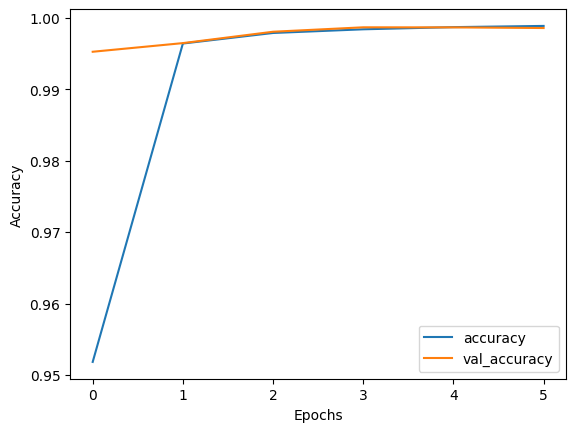

In [7]:
evaluator.accuracy(save_fig='accuracy_v3')

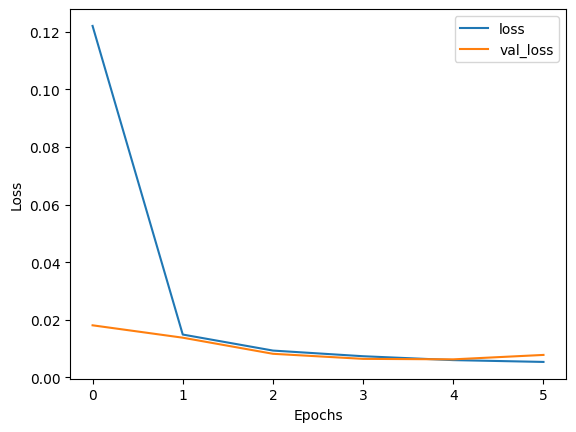

In [8]:
evaluator.loss(save_fig='loss_v3')

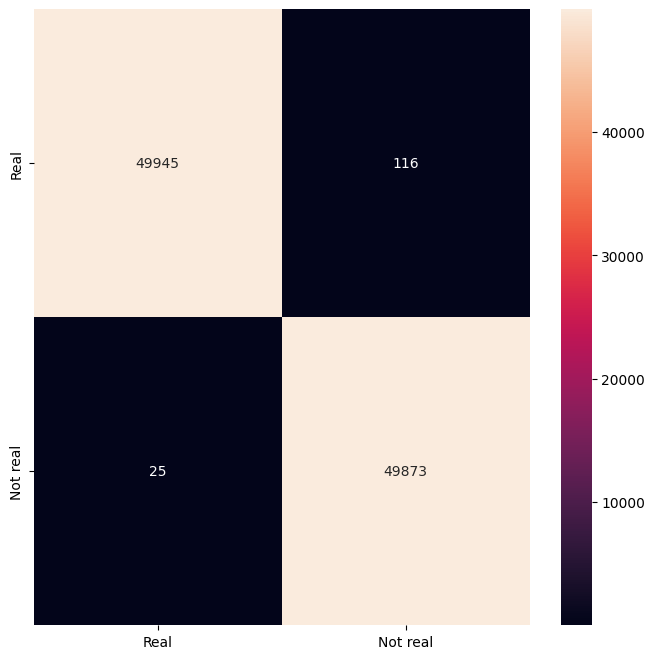

In [9]:
evaluator.confusion_matrix('confusion_matrix_v3')

In [10]:
print(evaluator.metrics_report())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50061
           1       1.00      1.00      1.00     49898

    accuracy                           1.00     99959
   macro avg       1.00      1.00      1.00     99959
weighted avg       1.00      1.00      1.00     99959



In [11]:
evaluator.get_missclassified_examples()

100%|██████████| 99959/99959 [00:00<00:00, 1128579.98it/s]


['راءة مصعب حاشد',
 'تانىن عثمان فعىن',
 'حنال على ازن',
 'ومى رسىم عبدالرق',
 'امامىان رحىق امجد',
 'نومى رشىق نذىر',
 'دعبل عشىر تاءب',
 'نورد قابوس جداح',
 'نعمت زاىد رحىق',
 'دعبل عبدالعلىم مدلج',
 'اهداف رحىق فكرى',
 'بارة جلىل خطىب',
 'عبدربه رحىق كنعان',
 'راءف رافى الىف',
 'ابرامىم رمضال عشىر',
 'اهل مستور هىثم',
 'امجى حصباح مىمون',
 'امىمة مدحة رحىق',
 'سدن عزىز تىم',
 'طىمان منان مهدى',
 'راضى ثاءر فجر',
 'رىماس اشرم ندرة',
 'مرح بهىج رحىق',
 'عبرالصمد عبادة وهاب',
 'حافص اىاد كلىم',
 'تغلىب وفىق فضىح',
 'عقىل حجاج رحىق',
 'مزهب منىع غصاب',
 'اسعاف حنشل انعم',
 'ىاسمىن عامر مبارك',
 'دعبل ناصر مفتاح',
 'عدا سارى ضاهد',
 'لهىرة سمىع زاخر',
 'رولا رحىق رجاء',
 'مباره سارح منىع',
 'انغام رحىق مدىد',
 'اظهار بال جامع',
 'داكا حطاء غفار',
 'ضىة عرفة اشىم',
 'هاءه ساءد فخرى',
 'دعبل كثىر تركى',
 'دعبل عىاش شافع',
 'وءوف عبدالباقى لىث',
 'راجح جبال جبلة',
 'روىشد جازم عاءذ',
 'راتبة غرىب رحىق',
 'اهاب رحىق غطاس',
 'باسق رحىق نشات',
 'عبدالعزىز راجى عثمان',
 'عاءشة ناجح فتوح',
 'شهد